# Experiment 1: LeNet5

In [1]:
# import modules
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import glob
import imageio
import utils.data_u as du
import seaborn as sns
%config IPCompleter.greedy=True

In [2]:
# Setup Images
data_directory = "data/"
df = pd.read_csv(data_directory+"train.csv")
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


(512, 512)


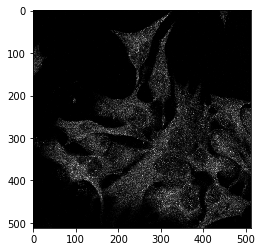

(512, 512)


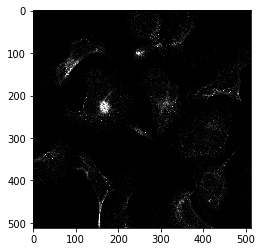

(512, 512)


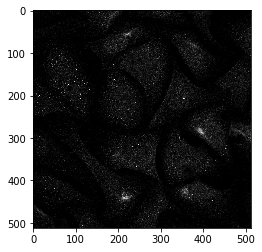

(512, 512)


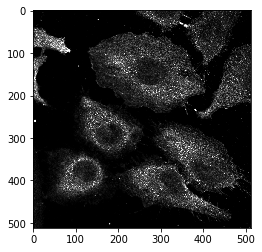

(512, 512)


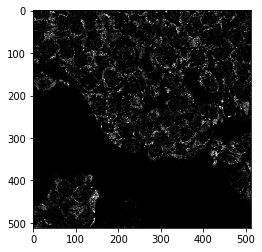

In [3]:
# looking at the first 5, we are interested in the proteins, so that the images *_green.png
import matplotlib.image as mpimg
count = 0;
for im_path in glob.glob(data_directory+"train/*_green.png"):
    if(count == 5): 
        break
    count+=1
    im = mpimg.imread(im_path)[:, :]
    print(im.shape)
    plt.figure(im_path)
    plt.imshow(im, cmap="gray")
    plt.show()
        

In [4]:
# One-hot encode targets
training_set = du.set_targets(df)
training_set = df.apply(du.fill_targets, axis=1)
training_set.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


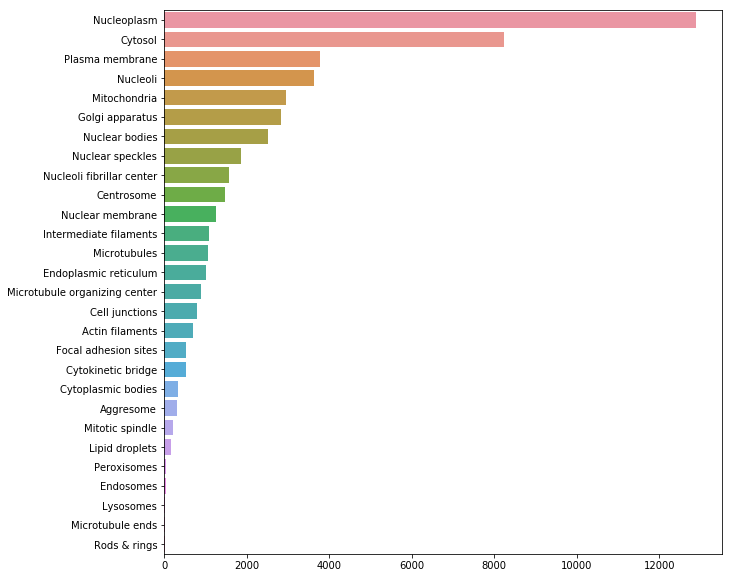

In [5]:
# show how much of each target there is
target_count = training_set.drop(["Id", "Target"], axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(y=target_count.index.values, x=target_count.values, order=target_count.index)

In [6]:
files_names, targets = np.asarray(training_set['Id'].apply(lambda x: f"{x}_green.png").tolist()), training_set.drop(["Id", "Target"], axis=1).values
print(files_names[0:5])
print(targets[0:5])
print(targets.shape)
print(files_names.shape)

['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png'
 '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png'
 '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_green.png'
 '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0_green.png'
 '001838f8-bbca-11e8-b2bc-ac1f6b6435d0_green.png']
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
(31072, 28)
(31072,)


In [7]:
# split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(files_names, targets, test_size=0.25)

In [8]:
X_test_image_names_25, y_test_25 = X_train[0:25], y_test[0:25]
X_test_image_25 = np.zeros((25, 512, 512, 1))
for i in range(0, len(X_test_image_names_25)):
        im_path = data_directory+"train/"+X_test_image_names_25[i]
        X_test_image_25[i, :, :, 0] = imageio.imread(im_path)
    

### Original LeNet5

In [9]:
def init_weight(shape):
    w = tf.truncated_normal(shape=shape, mean = 0, stddev = 0.1)
    return tf.Variable(w)

In [23]:
height, width, channels = 512, 512, 1

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, height, width, 1), name="X")
    y = tf.placeholder(tf.float32, shape=[None, 28], name="y")

with tf.name_scope("convNet"):
    conv1 = tf.nn.conv2d(input = X,
                         filter = init_weight((5,5,1,6)),
                         strides = [1,1,1,1],
                         padding = "VALID"
                        )
    conv1 = tf.nn.tanh(conv1)
    pool1 = tf.nn.avg_pool(value = conv1,
                           ksize = [1,2,2,1],
                           strides = [1,2,2,1],
                           padding = "VALID",
                          )
    pool1 = tf.nn.tanh(pool1)
    conv2 = tf.nn.conv2d(pool1, init_weight((5,5,6,16)), strides=[1,1,1,1], padding="VALID")
    conv2 = tf.nn.tanh(conv2)
    pool2 = tf.nn.avg_pool(conv2, [1,2,2,1], strides=[1,2,2,1], padding="VALID")
    pool2 = tf.nn.tanh(pool2)
    pool2_flat = tf.layers.flatten(pool2)

with tf.name_scope("fc"):
    fc1 = tf.layers.dense(pool2_flat, units=120, activation=tf.nn.tanh)
    fc2 = tf.layers.dense(fc1, units=84, activation=tf.nn.tanh)
    logits = tf.layers.dense(fc2, units=28)
    y_probs = tf.nn.sigmoid(logits)

with tf.name_scope("output"):
    entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(tf.reduce_sum(entropy, axis=1))
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))



In [24]:
init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 10
run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for offset in range(0, len(X_train) ,batch_size):
            batch_x_names, batch_y = X_train[offset:offset+batch_size], y_train[offset:offset+batch_size]
            batch_x = np.zeros((len(batch_x_names), height, width, 1))
            for i in range(0, len(batch_x_names)):
                im_path = data_directory+"train/"+batch_x_names[i]
                batch_x[i, :, :, 0] = imageio.imread(im_path)
            sess.run(training_op, feed_dict={X: batch_x, y: batch_y}, options=run_options)
        
#         acc_train = accuracy.eval(feed_dict={X: batch_x, y: y_batch})
#         acc_test = accuracy.eval(feed_dict={X: X_test_image_25, y: y_test_25})
#         print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

KeyboardInterrupt: 